In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import pickle
import networkx as nx

# Pre-compiled MIRA examples
from mira.examples.sir import sir_parameterized

%aimport pyciemss.utils

import torch
import torchdiffeq
import matplotlib.pyplot as plt
torch.manual_seed(42)

/Users/krue284/.pyenv/versions/anaconda3-2020.02/envs/CIEMSS_ENV/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from datetime import timedelta, date
import datetime as dt

def dates_to_tspan(date_dict,full_range=None):
    if full_range: # then make a subset of two dictionaries
        all_days = abs((full_range['end']  - full_range['start']).days)
        start    = abs((date_dict['start'] - full_range["start"]).days)
        end      = abs((date_dict['end']   - full_range["start"]).days)
        return torch.linspace(float(start),float(end),(end-start)+1)
    else: # then this is just a dict with the full range
        duration = abs((date_dict['end']   - date_dict['start']).days)
        return torch.linspace(1.,float(duration),duration)

def tspan_to_dates(tspan,subset,full_range=None): # project date forwards according to tspan
    if full_range: # then make a subset of two dictionaries
        duration = len(tspan)
        offset   = abs((subset['start'] - full_range['start']).days)
        return {'start':full_range['start']+timedelta(days=offset),'end':full_range['start']+timedelta(days=offset)+timedelta(days=duration)}
    else: # then this is just a dict with the full range
        return {'start':subset['start'],'end':subset['start']+timedelta(days=len(tspan))}
    
def plot_model(petri, solutions, dates):
    for i,context in enumerate(pyciemss.utils.get_mira_initial_values(petri).keys()):
        plt.scatter(dates, solutions[i], label=context)
    plt.xticks(rotation=45)
    plt.legend()

def plot_predictive(prediction, tspan, tmin=None, ax=None, alpha=0.2, color="black", **kwargs):
    vars = ["I_obs"]
    
    I_low = torch.quantile(prediction["I_obs"], 0.05, dim=0).detach().numpy()/1000
    I_up = torch.quantile(prediction["I_obs"], 0.95, dim=0).detach().numpy()/1000

    if tmin:
        indeces = tspan >= tmin
    else:
        indeces = torch.ones_like(tspan).bool()

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    
    ax.fill_between(tspan[indeces], I_low[indeces], I_up[indeces], alpha=alpha, color=color, **kwargs)

    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)

    return ax

def setup_ax(ax=None):

    if not ax:
        fig = plt.figure(facecolor='w', figsize=(9, 9))
        ax = fig.add_subplot(111, axisbelow=True)

    ax.set_xlabel('Time /days')
    ax.set_ylabel('Infected (1000s)')
    return ax

def plot_trajectory(data, tspan, ax=None, color='black', alpha=0.5, lw=0, marker='.', label=None):
    # Plot the data on three separate curves for S(t), I(t) and R(t)

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    ax.plot(tspan, data["I_obs"].squeeze().detach().numpy()/1000., color, alpha=alpha, lw=lw, marker=marker, label=label)
    
    return ax

def plot_intervention_line(t, ax=None):
    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    ylim = ax.get_ylim()

    ax.vlines(t, min(ylim), max(ylim), color="grey", ls='-')

    return ax

## Load Prior

In [20]:
import pyro
import numpy as np
import pyro.distributions as dist
from pyro.poutine import trace, replay, block
from pyro.infer.autoguide.guides import AutoDelta, AutoNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
pyro.set_rng_seed(0)

from pyciemss.utils import run_inference, get_tspan

observed_tspan = get_tspan(1, 7, 7)
new_tspan = get_tspan(7, 89, 83)
#new_tspan = get_tspan(7, 20, 20)
full_tspan = get_tspan(1, 89, 89)
#full_tspan = get_tspan(1, 20, 20)

num_samples = 25

# Total population, N.
N = 100000.0
# Initial number of infected and recovered individuals, I0 and R0.
V0, I0, Iv0, R0 = 0., 81.0, 0., 0.
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - Iv0 - V0 - R0

# 18 - 24 year olds
I_obs = torch.tensor([81.47, 84.3, 86.44, 89.66, 93.32, 94.1, 96.31])

initial_state = tuple(torch.as_tensor(s) for s in  (S0, V0, I0, Iv0, R0))
# normalize before passing to _simple
initial_state_norm = tuple(torch.as_tensor(s/N) for s in  (S0, V0, I0, Iv0, R0))
final_observed_state = tuple(torch.as_tensor(s) for s in  (S0, V0, I_obs[-1], Iv0, R0))

from pyciemss.ODE.models import SVIIvR_simple
noisy_ode_model = SVIIvR_simple(
                noise_var_prior=dist.Uniform(5.0, 10.),
                betaSI_prior   =dist.Uniform(0.1, 0.3),
                betaSIv_prior  =dist.Uniform(0.0125, 0.025),              
                betaVI_prior   =dist.Uniform(0.1, 0.3),
                betaVIv_prior  =dist.Uniform(0.0125, 0.025),
                gamma_prior    =dist.Uniform(0.05, 0.35),
                gammaV_prior   =dist.Uniform(0.1, 0.4),
                nu_prior       =dist.Uniform(0.001, 0.01))
ode_model = pyro.do(noisy_ode_model, {"noise_var": torch.tensor([0.000001])})

from pyciemss.ODE.models import SVIIvR
noisy_ode_model2 = SVIIvR(N, 
                noise_prior=dist.Uniform(5., 10.),
                beta_prior=dist.Uniform(0.1, 0.3), 
                betaV_prior=dist.Uniform(0.025, 0.05),
                gamma_prior=dist.Uniform(0.05, 0.35),
                gammaV_prior=dist.Uniform(0.1, 0.4),
                nu_prior=dist.Uniform(0.001, 0.01))
ode_model2 = pyro.do(noisy_ode_model2, {"noise_var": torch.tensor([0.000001])})

initial_state (tensor(99919.), tensor(0.), tensor(81.), tensor(0.), tensor(0.))
initial_state_norm (tensor(0.9992), tensor(0.), tensor(0.0008), tensor(0.), tensor(0.))


In [12]:
## view insides of the code to diagnose the derivative
# import inspect
# print(inspect.getsource(SVIIvR_simple.deriv))

    @pyro_method
    def deriv(self, t: Time, state: State) -> State:
        S, V, I, Iv, R = state

        # Local fluxes exposed to pyro for interventions.
        # Note: This only works with solvers that use fixed time increments, such as Euler's method. Otherwise, we have name collisions.
        SV_flux_  = pyro.deterministic("SV_flux %f" % (t),  self.nu * S)
        SI_flux_  = pyro.deterministic("SI_flux %f" % (t),  self.betaSI * S * I)
        SIv_flux_ = pyro.deterministic("SIv_flux %f" % (t), self.betaSIv * S * Iv)
        VI_flux_  = pyro.deterministic("VI_flux %f" % (t),  self.betaVI * V * I)
        VIv_flux_ = pyro.deterministic("VIv_flux %f" % (t), self.betaVIv * V * Iv)
        IR_flux_  = pyro.deterministic("IR_flux %f" % (t),  self.gamma * I)
        IvR_flux_ = pyro.deterministic("IvR_flux %f" % (t), self.gammaV * Iv)

        # these state_flux_constraints ensure that we don't have vaccinated people become susceptible, etc.
        SV_flux  = state_flux_constrain

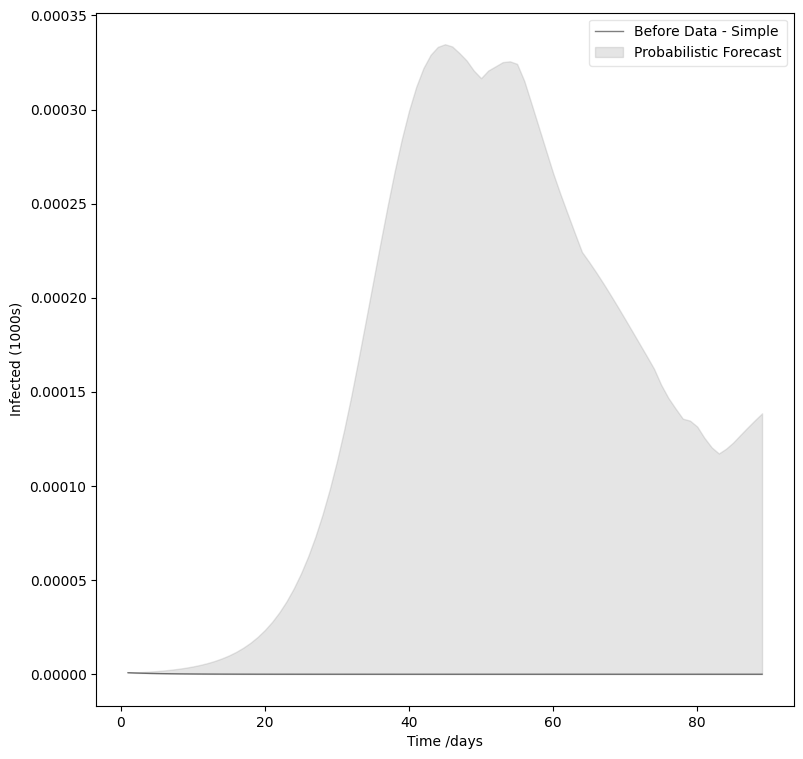

In [21]:
prior_prediction  = Predictive(ode_model, num_samples=num_samples)(initial_state_norm, full_tspan)
single_prediction = Predictive(ode_model, num_samples=1)(initial_state_norm, full_tspan)
#prior_prediction2  = Predictive(ode_model2, num_samples=num_samples)(initial_state, full_tspan)
#single_prediction2 = Predictive(ode_model2, num_samples=1)(initial_state, full_tspan)

ax = plot_trajectory(single_prediction, full_tspan, ax=setup_ax(), color="black", marker='', lw=1., label="Before Data - Simple")
ax = plot_predictive(prior_prediction, full_tspan, ax=ax, label="Probabilistic Forecast", color="grey")
#ax = plot_trajectory(single_prediction2, full_tspan, ax=ax, color="blue", marker='', lw=1., label="Before Data - DecDemo")
#ax = plot_predictive(prior_prediction2, full_tspan, ax=ax, label="Probabilistic Forecast", color="red")

## Get Posterior

In [22]:
guide = AutoNormal(block(noisy_ode_model, hide=["S_obs", "V_obs", "Iv_obs", "R_obs"]))
data = {"S_obs":None, "V_obs":None, "I_obs":torch.div(I_obs,N), "Iv_obs":None, "R_obs":None}

run_inference(noisy_ode_model, guide, initial_state_norm, observed_tspan, data, num_iterations=200, verbose=False)

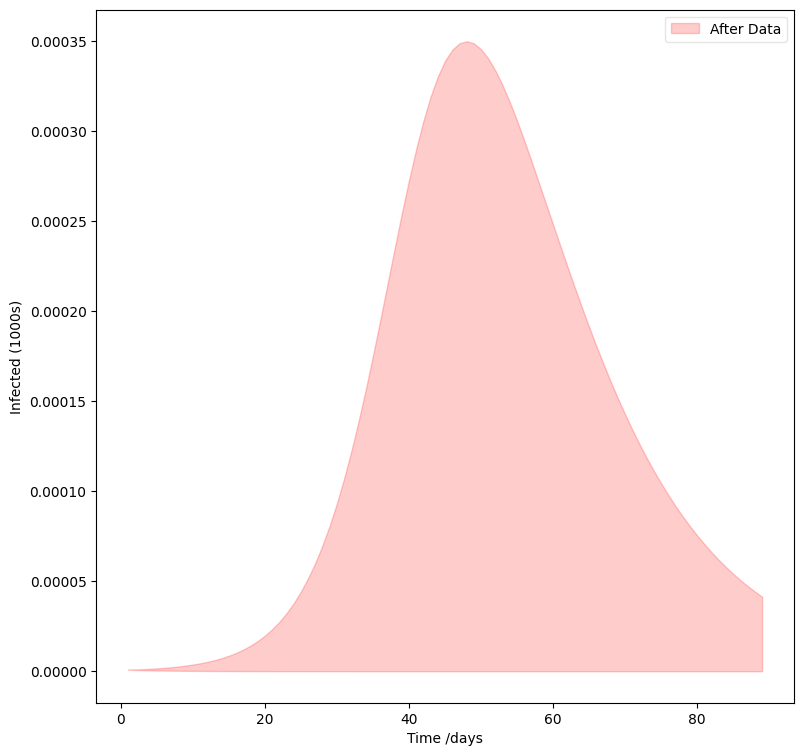

In [25]:
#optimal_intv_model = pyro.do(ode_model, constant_intervention("betaSIv", torch.tensor([0.15]), new_tspan))
#optimal_intv_model = pyro.do(optimal_intv_model, parameter_intervention("noise_var", torch.tensor([0.000001])))
prior_prediction   = Predictive(ode_model, num_samples=10)(initial_state_norm, full_tspan)
#prior_prediction2  = Predictive(optimal_intv_model, num_samples=N_SAMPLES)(initial_state, new_tspan)

ax = plot_predictive(prior_prediction, full_tspan, ax=setup_ax(), label="After Data", color="red")
#ax = plot_predictive(prior_prediction2, new_tspan, ax=ax, label="After Intervention", color="black")

In [13]:
#### 
# from pyro.poutine import trace
# observed_tspan = get_tspan(1, 7, 7)

# def get_variables_from_trace(model, *args, **kwargs):
#     tr = trace(model).get_trace(*args, **kwargs)
#     return tr.nodes.items()

# for key, value in get_variables_from_trace(noisy_ode_model, initial_state, observed_tspan):
#     #if '_' != key[0]:
#     #    print(key)
#     if key == 'betaSI': print(value)

{'type': 'sample', 'name': 'betaSI', 'fn': Uniform(low: 0.10000000149011612, high: 0.30000001192092896), 'is_observed': False, 'args': (), 'kwargs': {}, 'value': tensor(0.2583), 'infer': {}, 'scale': 1.0, 'mask': None, 'cond_indep_stack': (), 'done': True, 'stop': False, 'continuation': None}


## Optimize

In [26]:
### how much mitigation do we need to keep H+Hv below 3K
from pyciemss.risk.ouu import computeRisk, solveOUU
from pyciemss.risk.qoi import threshold_exceedence
from pyciemss.risk.risk_measures import pof
from pyciemss.ODE.interventions import constant_intervention, parameter_intervention

# t_dates  = {"start":date(2021, 12, 29), "end":date(2022,  1,  3)}
# t  = dates_to_tspan(t,t0)
# print(t)

ALPHA = 0.95

INTERVENTION_FN = lambda x: constant_intervention("betaSI", torch.from_numpy(x), new_tspan)

# Define problem specifics.
old_beta = 0.3
RISK_BOUND = 0.05
BETA_MIN = 0.
BETA_MAX = old_beta

BETA_INITIAL = 0.001

N_SAMPLES = int(1e2)
MAXITER = 10
TOL = 1e-5

OBJFUN = lambda x: x

GETRISK = computeRisk(
    model        = noisy_ode_model,
    qoi          = lambda y: threshold_exceedence(y, threshold=0.35, contexts=["I_obs"]),
    risk_measure = lambda z: pof(z, threshold=0.5),
    intervention_fun = INTERVENTION_FN,
    model_state  = final_observed_state,
    tspan        = new_tspan
)

O = solveOUU(x0          = BETA_INITIAL,
             objfun      = lambda x: np.abs(old_beta - x), # minimize difference
             constraints =[{'type':"ineq",'fun':lambda x: x - BETA_MIN}, #  low bound
                           {'type':"ineq",'fun':lambda x: BETA_MAX - x}, # high bound
                           {"type":"ineq","fun":lambda x: RISK_BOUND - GETRISK(x)}],
             optimizer_algorithm = "COBYLA",
             tol                 = TOL,
             options             = {"maxiter": MAXITER}
            )

sol = O.solve()
             
print(sol["x"][0]) # optimal result
print(abs(sol["x"][0] - old_beta)/old_beta*100) # percent difference

0.3135
4.5000000000000036


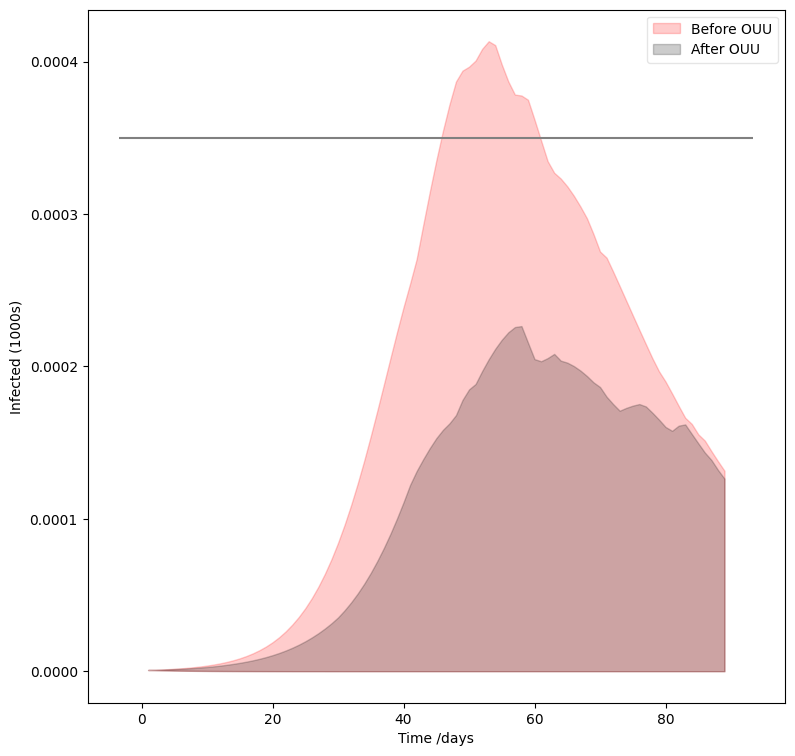

In [27]:
optimal_intv_model = pyro.do(ode_model, constant_intervention("betaSIv", torch.tensor([0.15]), new_tspan))
#optimal_intv_model = pyro.do(optimal_intv_model, parameter_intervention("noise_var", torch.tensor([0.000001])))
prior_prediction   = Predictive(ode_model, num_samples=N_SAMPLES)(initial_state_norm, full_tspan)
prior_prediction2  = Predictive(optimal_intv_model, num_samples=N_SAMPLES)(initial_state_norm, full_tspan)

ax = plot_predictive(prior_prediction, full_tspan, ax=setup_ax(), label="Before OUU", color="red")
ax = plot_predictive(prior_prediction2, full_tspan, ax=ax, label="After OUU", color="black")

xlim = ax.get_xlim()
ax = ax.hlines(0.00035, min(xlim), max(xlim), color="grey", ls='-')

In [ ]:
optimal_intv_model = pyro.do(ode_model, constant_intervention("betaSI", sol["x"][0], new_tspan))
optimal_intv_model = pyro.do(optimal_intv_model, {"noise_var": torch.tensor([0.000001])})
prior_prediction   = Predictive(ode_model, num_samples=N_SAMPLES)(initial_state, get_tspan(1,20,20))
prior_prediction2  = Predictive(optimal_intv_model, num_samples=N_SAMPLES)(initial_state, get_tspan(1,20,20))

ax = plot_predictive(prior_prediction, get_tspan(1,20,20), ax=setup_ax(), label="Before Data", color="red")
ax = plot_predictive(prior_prediction2, get_tspan(1,20,20), ax=ax, label="After Data", color="black")

xlim = ax.get_xlim()
ax = ax.hlines(30, min(xlim), max(xlim), color="grey", ls='-')

## Test Risk Calculation

In [61]:
POLICY = np.array([0.035])

SAMPLES = GETRISK.propagate_uncertainty(POLICY)
qois = GETRISK.qoi(SAMPLES)

print(f"Risk value might be:\t{GETRISK.risk_measure(qois):.2f}")

Risk value might be:	0.10


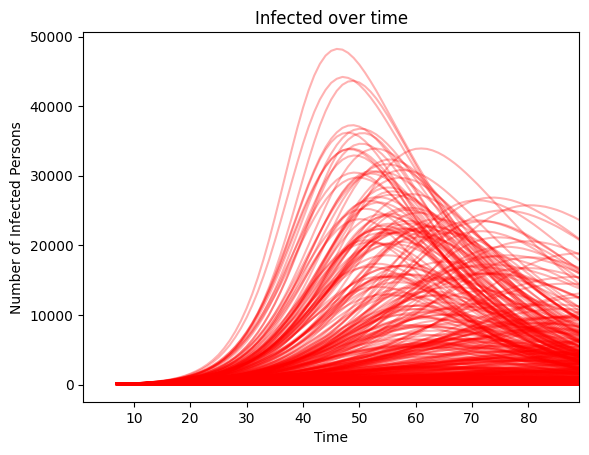

In [62]:
plt.plot(new_tspan.detach().numpy(), SAMPLES["I_obs"].detach().numpy().T, color='r', alpha=0.3)
plt.xlim(full_tspan[0], full_tspan[-1])
plt.xlabel("Time")
plt.ylabel("Number of Infected Persons")
plt.title("Infected over time")
plt.show()

In [ ]:
POLICY = np.array([0.5])

SAMPLES = GETRISK.propagate_uncertainty(POLICY)
qois = GETRISK.qoi(SAMPLES)

print(f"Risk value might be:\t{GETRISK.risk_measure(qois):.2f}")

plt.plot(new_tspan.detach().numpy(), SAMPLES["I_obs"].detach().numpy().T, color='b', alpha=0.3)
plt.xlim(full_tspan[0], full_tspan[-1])
plt.xlabel("Time")
plt.ylabel("Number of Infected Persons")
plt.title("Infected over time")
plt.show()

In [ ]:
GETRISK.intervention_fun(POLICY)